## Extracting drug assosiations

This notebook runs part of the Multi-Omics Variational autoEncoder (MOVE) framework for using the structure the VAE has identified for extracting categorical data assositions across all continuous datasets. In the MOVE paper we used it for identifiying drug assosiations in clinical and multi-omics data. Before running this part you need to have the optmial hyperparameters identified using the guide in the notebooks <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i> and <i>MOVE_hyperparameter_optimization_stability.ipynb</i> . We also recommend doing the latent space analysis as well to make sure the network has captured a meaningful structure as descriped in <i>latent_space_analysis.ipynb</i>. 

In [1]:
# Load functions
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
from collections import defaultdict
import scipy
from scipy import stats
from statsmodels.stats.multitest import multipletests
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import random
import copy
import scipy
from scipy import stats
matplotlib.use('agg')
plt.style.use('seaborn-whitegrid')

import os, sys
import torch
import numpy as np
from torch.utils import data
import re 

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import itertools

from utils.data_utils import *

/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
# Load MOVE specific funtions
path = "./"
sys.path.append(path + "src/")
import VAE_v2_1

Below is the functions for calculating the changes defined. In the MOVE paper the drug changes/assosiations were only calculated for those not taking a drug in the same ATC group using the funtion <i>change_drug_atc</i>. In the notebook the code is run without this feature using the <i>change_drug</i> function. 

In [3]:
# Functions for calculations

def get_baseline(model, train_loader, con_recon, repeat=25, kld_w=0):
   recon_diff_baseline = list()
   for r in range(repeat):
      latent_new, latent_var_new, cat_recon_new, cat_class_new, con_recon_new, test_loss_new, likelihood_new = model.latent(train_loader, kld_w)
   
      recon_diff = con_recon_new - np.array(con_recon) 
      recon_diff_baseline.append(recon_diff)
   
   matrix = np.array(recon_diff_baseline)
   baseline_mean = np.mean(matrix, axis= 0)
   baseline_mean = np.where(train_loader.dataset.con_all == 0, np.NaN , baseline_mean)
   return baseline_mean

def change_drug_atc(train_loader, trans_table, con_recon, drug, types = [[1,0]], data_start=1557):
   types = np.array(types)
   
   recon_diff_con_none = dict()
   none_groups = dict()
   data_shapes = drug.shape
   data_end = train_loader.dataset.cat_all.shape[1]
   for feature_index in range(data_shapes[1]):
      atc = trans_table[drug_h[feature_index]]
      same_atc = [k for k, v in trans_table.items() if (v == atc and k != drug_h[feature_index])]
      same = 0
      drug_indexes = []
      if len(same_atc) > 0:
         same = 1
         for i in same_atc:
            drug_indexes.append(drug_h.index(i))
      
      data = np.array(train_loader.dataset.cat_all)
      
      for t in types:
         tmp_data = np.copy(data[:,data_start:data_end])
         tmp_data = tmp_data.reshape(tmp_data.shape[0], data_shapes[1], data_shapes[2])
         tmp_data[:,feature_index,:] = t
         
         same_group = [True] * data.shape[0]
         none_group = [True] * data.shape[0]
         if same != 0:
            for i in drug_indexes:
               same_group_tmp = [(np.all(a_s == types[0])) for a_s in drug[:,i,:]]
               none_group_tmp = [not (np.all(a_s == types[0]) or (np.all(a_s == [0,0]))) for a_s in drug[:,i,:]]
               
               same_group = [all(tup) for tup in zip(same_group, same_group_tmp)]
               none_group = [all(tup) for tup in zip(none_group, none_group_tmp)]
         
         tmp_data = tmp_data.reshape(tmp_data.shape[0], -1)
         new_data = np.copy(data)
         new_data[:,data_start:data_end] = tmp_data
         new_data = torch.from_numpy(new_data)
         
         none_groups[feature_index] = none_group
         new_data = new_data[none_group,:]
         dataset = VAE_v2_1.Dataset(new_data, train_loader.dataset.con_all[none_group,:], train_loader.dataset.con_shapes, train_loader.dataset.cat_shapes)
         
         new_loader = DataLoader(dataset, batch_size=train_loader.batch_size, drop_last=False,
                           shuffle=False, num_workers=1, pin_memory=train_loader.pin_memory)
         
         latent_new, latent_var_new, cat_recon_new, cat_class_new, con_recon_new, test_loss_new, likelihood_new = model.latent(new_loader, kld_w)
         
         recon_diff = (con_recon_new - np.array(con_recon[none_group,:]))
         recon_diff_con_none[feature_index] = recon_diff
   
   return recon_diff_con_none,none_groups


def change_drug(model, train_loader, con_recon, drug, start, end, kld_w, types = [[1,0]]):
   types = np.array(types)
   
   recon_diff_con_none = dict()
   none_groups = dict()
   data_shapes = drug.shape
   data_start = start
   data_end = end #train_loader.dataset.cat_all.shape[1] # todo: Change to the end of the category 
   for feature_index in range(data_shapes[1]):
      data = np.array(train_loader.dataset.cat_all)
      for t in types:
         tmp_data = np.copy(data[:,data_start:data_end])
         tmp_data = tmp_data.reshape(tmp_data.shape[0], data_shapes[1], data_shapes[2])
         tmp_data[:,feature_index,:] = t
         
         none_group = [True] * data.shape[0]
         
         tmp_data = tmp_data.reshape(tmp_data.shape[0], -1)
         new_data = np.copy(data)
         new_data[:,data_start:data_end] = tmp_data
         new_data = torch.from_numpy(new_data)
         
         none_groups[feature_index] = none_group
         dataset = VAE_v2_1.Dataset(new_data, train_loader.dataset.con_all, train_loader.dataset.con_shapes, train_loader.dataset.cat_shapes)
         
         new_loader = DataLoader(dataset, batch_size=train_loader.batch_size, drop_last=False,
                           shuffle=False,  pin_memory=train_loader.pin_memory) #num_workers=1,
         
         latent_new, latent_var_new, cat_recon_new, cat_class_new, con_recon_new, test_loss_new, likelihood_new = model.latent(new_loader, kld_w)
         
         recon_diff = (con_recon_new - np.array(con_recon))
         recon_diff_con_none[feature_index] = recon_diff
   
   return recon_diff_con_none,none_groups


def cal_sig_hits(recon_diff_con_none, none_groups, drug, baseline_mean, con_all, types = [[1,0]]):
   data_shapes = drug.shape
   none_avg = list()
   none_stats = list()
   for f in range(0,data_shapes[1]):
      if f in none_groups:
         tmp = np.copy(recon_diff_con_none[f])
         tmp_data = con_all[none_groups[f],:]
         tmp_baseline = baseline_mean[none_groups[f],:]
         g = [not (np.all(a_s == types[0]) or (np.all(a_s == [0,0]))) for a_s in drug[none_groups[f],f,:]]
         tmp = np.where(tmp_data[g,:] == 0,np.NaN, tmp[g,:])
         tmp_abs = np.abs(tmp)
         stat = stats.ttest_rel(tmp, tmp_baseline[g,:], axis=0, nan_policy="omit")
         
         if np.all(np.isnan(stat[1])):
            p_stat = np.zeros((con_all.shape[1]))
            p_stat[:] = np.nan
         else:
            p_stat = stat[1]
         
         none_stats.append(p_stat)
         avg = np.nanmean(tmp, axis = 0)
         avg[np.isnan(avg)] = 0
         none_avg.append(avg)
      else:
         tmp = np.zeros((tmp_data.shape[1]))
         tmp[:] = np.nan
         none_avg.append(tmp)
         none_stats.append(tmp)
   
   none_avg = np.array(none_avg)
   none_stats = np.array(none_stats)
   
   return none_stats

def correction_new(results):
   new_results = defaultdict(dict)
   for l in results:
      for r in range(len(results[l])):
         corrected = np.zeros((results[l][r].shape[0],results[l][r].shape[1]))
         for d in range(results[l][r].shape[0]):
            stats_cor = multipletests(results[l][r][d,:], method = "bonferroni")[1]
            corrected[d,:] = stats_cor
         
         new_results[r][l] = corrected
   
   return new_results

The next part reads in the data. NOTE the data is not available (replace with own files)

In [4]:
data_dict = read_yaml('data')
cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(data_dict)

In [5]:
def get_start_end_positions(cat_list, data_dict):
  
  n_cat = 0
  cat_shapes = list()
  cat_all = []
  first = 0
  for i in range(len(data_dict['categorical_data_files'])):
    cat_d = cat_list[i]
    
    cat_shapes.append(cat_d.shape)
    cat_input = cat_d.reshape(cat_d.shape[0], -1)
    
    
    if first == 0:
      cat_all = cat_input
      del cat_input
      first = 1
    
      if data_dict['data_of_interest'] == data_dict['categorical_data_files'][i]:
        start = 0
        end = cat_all.shape[-1]
    else:
      cat_all = np.concatenate((cat_all, cat_input), axis=1)
      
      if data_dict['data_of_interest'] == data_dict['categorical_data_files'][i]:
        start = cat_all.shape[-1] - cat_input.shape[-1]
        end = cat_all.shape[-1]
    
  # Make mask for patients with no measurments
  catsum = cat_all.sum(axis=1)
  mask = catsum > 5
  del catsum
  return start, end

In [6]:
# Intilize variables
cuda = False

nLatents = [150, 200, 250, 300]

nepochs=1
lrate=0.0001
kldsteps=[15, 20, 25]
batchsteps=[50, 100, 150]
l = len(kldsteps)
rate = 20/l
# update = 1 + rate
repeats = 1
version = "v1"

In [7]:
#TODOs: take out nHiddens, nlatent, beta, droput out of function; also r
def train_model(path, cuda, nepochs, nLatents, con_list, cat_list, version):

   results, recon_results, recon_results_1, mean_bas = initiate_default_dicts(n_empty_dicts=0, n_list_dicts=4)

   device = torch.device("cuda" if cuda == True else "cpu")
   
   data_dict = read_yaml('data')
   start, end = get_start_end_positions(cat_list, data_dict)

   iters = itertools.product(nLatents, range(repeats))
   # Running the framework
   for l, repeat in iters: 
      mask, train_loader = VAE_v2_1.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize=10)

      ncontinuous = train_loader.dataset.con_all.shape[1]
      con_shapes = train_loader.dataset.con_shapes

      ncategorical = train_loader.dataset.cat_all.shape[1]
      cat_shapes = train_loader.dataset.cat_shapes

      model = VAE_v2_1.VAE(ncategorical=ncategorical, ncontinuous=ncontinuous, con_shapes=con_shapes,
                     cat_shapes=cat_shapes, nhiddens=[2000], nlatent=l,
                     beta=0.0001, cat_weights=[1,1,1], con_weights=[2,1,1,1,1,1,1], dropout=0.1, cuda=cuda).to(device)

      update = 1 + rate
      kld_w = 0
    
      for epoch in range(1, nepochs + 1):

         if epoch in kldsteps:
            kld_w = 1/20 * update
            update += rate

         if epoch in batchsteps:
                  train_loader = DataLoader(dataset=train_loader.dataset,
                                          batch_size=int(train_loader.batch_size * 1.5),
                                          shuffle=True,
                                          drop_last=True,
                                          pin_memory=train_loader.pin_memory) # num_workers=train_loader.num_workers,

         tmp_res = model.encoding(train_loader, epoch, lrate, kld_w)

      train_test_loader = DataLoader(dataset=train_loader.dataset, batch_size=train_loader.batch_size, drop_last=False,
                              shuffle=False, pin_memory=train_loader.pin_memory) #num_workers=1,

      latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = model.latent(train_test_loader, kld_w)

      con_recon = np.array(con_recon)
      con_recon = torch.from_numpy(con_recon)

      mean_baseline = get_baseline(model, train_test_loader, con_recon, repeat=1, kld_w=kld_w)
      recon_diff, groups = change_drug(model, train_test_loader, con_recon, drug, start, end, kld_w) #TODO: when the drug data starts 
      stat = cal_sig_hits(recon_diff, groups, drug, mean_baseline, train_loader.dataset.con_all)

      results[l].append(stat)
      recon_diff_corr = dict()
      for r_diff in recon_diff.keys():
         recon_diff_corr[r_diff] = recon_diff[r_diff] - np.abs(mean_baseline[groups[r_diff]])

      mean_bas[l].append(mean_baseline)
      recon_results[l].append(recon_diff_corr)
      recon_results_1[l].append(recon_diff)
    
    
    # Saving results

   with open(path + "results/results_" + version + ".npy", 'wb') as f:
      np.save(f, results)
   with open(path + "results/results_recon_" + version + ".npy", 'wb') as f:
      np.save(f, recon_results)
   with open(path + "results/results_groups_" + version + ".npy", 'wb') as f:
      np.save(f, groups)
   with open(path + "results/results_recon_mean_baseline_" + version + ".npy", 'wb') as f:
      np.save(f, mean_bas)
   with open(path + "results/results_recon_no_corr_" + version + ".npy", 'wb') as f:
      np.save(f, recon_results_1)
    
   cor_results = correction_new(results)
    
   with open(path + "wp2.2/sig_overlap/cor_results_" + version + ".npy", 'wb') as f:
      np.save(f, cor_results)
 
train_model(path, cuda, nepochs, nLatents, con_list, cat_list, version)

	Epoch: 1	Loss: 13.973151	CE: 3.6952168	SSE: 10.277934	KLD: 0.0000	Batchsize: 10
====> Test set loss: 13.6547
====> Test set loss: 13.6623
====> Test set loss: 13.6319
====> Test set loss: 13.6607
====> Test set loss: 13.7209
====> Test set loss: 13.6484
====> Test set loss: 13.5820
====> Test set loss: 13.6604
====> Test set loss: 13.6787
====> Test set loss: 13.6009
====> Test set loss: 13.6663
====> Test set loss: 13.6015
====> Test set loss: 13.6313
====> Test set loss: 13.7501
====> Test set loss: 13.7447
====> Test set loss: 13.6105
====> Test set loss: 13.6295
====> Test set loss: 13.6338
====> Test set loss: 13.7057
====> Test set loss: 13.6225
====> Test set loss: 13.6937
====> Test set loss: 13.6496
	Epoch: 1	Loss: 14.030294	CE: 3.6922631	SSE: 10.338031	KLD: 0.0000	Batchsize: 10
====> Test set loss: 13.5496
====> Test set loss: 13.5137
====> Test set loss: 13.5317
====> Test set loss: 13.5466
====> Test set loss: 13.5526
====> Test set loss: 13.5465
====> Test set loss: 13.53

In [7]:
results = np.load(path + "results/results_" + version + ".npy", allow_pickle=True).item()
recon_results = np.load(path + "results/results_recon_" + version + ".npy", allow_pickle=True).item()
groups = np.load(path + "results/results_groups_" + version + ".npy", allow_pickle=True).item()
mean_bas = np.load(path + "results/results_recon_mean_baseline_" + version + ".npy", allow_pickle=True).item()
recon_results_1 = np.load(path + "results/results_recon_no_corr_" + version + ".npy", allow_pickle=True).item()
cor_results = np.load(path + "wp2.2/sig_overlap/cor_results_" + version + ".npy", allow_pickle=True).item()


The next part goes over the data and calcualte overlapping results using the different latent space sizes over the 10 repates. Here, only results with significant changes (adj. p-value < 0.05) in at least 5 out of the 10 repeats in 3 of the 4 latent sizes are considered. 

In [9]:
# Calculating the size of reconstruction change across repeats
# process recon data

def cal_reconstruction_change(recon_results):
   recon_average = dict()
   for l in recon_results.keys():
      average = defaultdict(dict)
      for r in range(len(recon_results[l])):
         for d in range(len(recon_results[l][r])):
            tmp_recon = recon_results[l][r][d]
            if d in average:
               average[d] = np.add(average[d], tmp_recon)
            else:
               average[d] = tmp_recon
      a = {k: (v / repeats) for k, v in average.items()}
      recon_average[l] = a
   return(recon_average)

recon_average = cal_reconstruction_change(recon_results)

In [10]:
# Identified overlapping hits in the repeats on the same latent size

# Look at overlaps
def overlapping_hits(nLatents, cor_results, repeats, con_names, drug): # TODOs: con_names and drug come from function return
   sig_hits = defaultdict(dict)
   overlaps_d = defaultdict(list)
   counts = list()

   new_list = nLatents[::-1]
   # con_names = np.array(con_names)
   median_p_val = defaultdict(dict)
   for l in range(len(new_list)):
      for d in range(cor_results[0][new_list[l]].shape[0]):
         hits_tmp = list()
         p_cors = defaultdict(list)
         for repeat in range(repeats):

            ns = con_names[cor_results[repeat][new_list[l]][d,:] <= 0.05]

            p_cor = cor_results[repeat][new_list[l]][d,:]
            p_cor = p_cor[p_cor <= 0.05]
            for i,ns_t in enumerate(ns):
               p_cors[ns_t].append(p_cor[i])

            hits_tmp.extend(ns)

         overlap_tmp = [hits_tmp.count(x) for x in np.unique(hits_tmp)]
         overlap = np.array(np.unique(hits_tmp))[np.array(overlap_tmp) >= 5]
         m_p = []
         for o_t in overlap:
           m_p.append(np.median(p_cors[o_t]))

         sig_hits[d][new_list[l]] = overlap
         median_p_val[d][new_list[l]] = m_p
   return(sig_hits, median_p_val)

sig_hits, median_p_val = overlapping_hits(nLatents, cor_results, repeats, con_names, drug)

In [11]:
# Get hits found for the different latent sizes - the result can be used to 
# further analyse the low to high supportted hits
def identify_high_supported_hits(sig_hits, drug_h, version): # drug_h comes from the function
   result = dict()
   collected_overlap = defaultdict(list)
   all_hits = list()
   for d in sig_hits:
      result[drug_h[d]] = defaultdict(list)
      all_h = []
      for l in sig_hits[d]:
         all_h.extend(sig_hits[d][l])

      for x in set(all_h):
         if all_h.count(x) >=3:
            result[drug_h[d]]['high'].append(x)
         elif all_h.count(x) == 2:
            result[drug_h[d]]['medium'].append(x)
         else:
            result[drug_h[d]]['low'].append(x)

         if all_h.count(x) >= 3:
            collected_overlap[drug_h[d]].append(x)
            all_hits.append(x)
   
   # Save result
   np.save(path + "results/results_confidence_" + version + ".npy", result)

   return(all_hits, collected_overlap)

all_hits, collected_overlap = identify_high_supported_hits(sig_hits, drug_h, version)

For reporting of results the median p-value is used across the different runs for the hits surviving the thresholds

In [12]:
def report_values(path, sig_hits, median_p_val, drug_h, all_hits, con_names): #TODO: drugs come from defined func

    results_folder = path + 'results/sig_ci_files'
    isExist = os.path.exists(results_folder)
    if not isExist:
      os.makedirs(results_folder)

    p_vals = list()
    for d in sig_hits:
       p_vals_col = []
       p_vals_tmp = defaultdict(list)
       for l in sig_hits[d]:
          name_s = sig_hits[d][l]
          ps = median_p_val[d][l]
          for i,ns_1 in enumerate(name_s):
            if ns_1 in collected_overlap[drug_h[d]]:
                p_vals_tmp[ns_1].append(ps[i])

       m_p_vals_tmp = dict()
       for ns_2 in p_vals_tmp:
          m_p_vals_tmp[ns_2] = np.median(p_vals_tmp[ns_2])

       for a_h in all_hits:
          if a_h in m_p_vals_tmp:
             p_vals_col.append(m_p_vals_tmp[a_h])
          else:
             p_vals_col.append('ns')

       p_vals.append(p_vals_col)

    p_vals_df = pd.DataFrame(p_vals, index=drug_h, columns=all_hits)

    # Save the files for each continuous dataset
    for i,al_con in enumerate(con_names):
       sig_drug_names = np.intersect1d(all_hits, al_con)
       df_tmp = p_vals_df.loc[:, sig_drug_names]
       df_tmp.T.to_csv(path + "results/sig_ci_files/" + con_names[i] + "_p_vals.txt", sep = "\t")

report_values(path, sig_hits, median_p_val, drug_h, all_hits, con_names)

In order to get the change in reconstruction (effect of changeing the drug) we calcualted the average change across all the repeats and latent sizes. For this we included all changes for non-significant hits and for those identified as significant only the repeats and latent size with a significant change was used. The change was both calcualted on average for all individuals not already taking the drug and save for each individual to look into the individual level variation. 

In [ ]:
import tqdm

def get_change_in_reconstruction(recon_average, groups, drug, con_names, collected_overlap, sig_hits, con_all, version): 
   types = [[1, 0]] #TODOs: Should types be really like this?  #Change only in this notebook

   recon_average_corr_all = dict()
   counts_average_all = dict()
   recon_average_corr_all_indi = dict()
   counts_indi = dict()

   for l in recon_average.keys():
      for d in recon_average[l].keys():
         print(d)
         tmp_recon = np.copy(recon_average[l][d])
         gr = groups[d]
         g = [not (np.all(a_s == types[0]) or (np.all(a_s == [0,0]))) for a_s in drug[gr,d,:]]
         tmp_recon = tmp_recon[g]

         if d not in recon_average_corr_all:
            recon_average_corr_all[d] = [0] * len(con_names)
            counts_average_all[d] = [0] * len(con_names)
            recon_average_corr_all_indi[d] = [[0] * tmp_recon.shape[1]] * tmp_recon.shape[0]
            counts_indi[d] = [[0] * tmp_recon.shape[1]] * tmp_recon.shape[0]

         for f in tqdm.tqdm(range(tmp_recon.shape[1])):
            if con_names[f] in collected_overlap[drug_h[d]]:
               if con_names[f] in sig_hits[d][l]:
                  tmp_vals = con_all[groups[d],f]
                  tmp_vals = tmp_vals[g]
                  avg_tmp = np.mean(tmp_recon[tmp_vals != 0,f])
                  recon_average_corr_all[d][f] += avg_tmp
                  counts_average_all[d][f] += 1

                  for indi in range(tmp_recon.shape[0]):
                     if tmp_vals[indi] != 0:
                        recon_average_corr_all_indi[d][indi][f] += tmp_recon[indi,f]
                        counts_indi[d][indi][f] += 1
            else:
               tmp_vals = con_all[groups[d],f]
               tmp_vals = tmp_vals[g]
               avg_tmp = np.mean(tmp_recon[tmp_vals != 0,f])
               recon_average_corr_all[d][f] += avg_tmp
               counts_average_all[d][f] += 1

               for indi in range(tmp_recon.shape[0]):
                  if tmp_vals[indi] != 0:
                     recon_average_corr_all_indi[d][indi][f] += tmp_recon[indi,f]
                     counts_indi[d][indi][f] += 1
      break
   recon_average_corr_new_all = list()
   recon_average_corr_all_indi_new = dict()
   for d in recon_average_corr_all.keys():
      print(d)
      counts_tmp = np.array(counts_average_all[d])
      tmp_l = np.array(recon_average_corr_all[d])[counts_tmp != 0]
      included_names = con_names[counts_tmp != 0]
      counts_tmp = counts_tmp[counts_tmp != 0]
      recon_average_corr_new_all.append(tmp_l/counts_tmp)

      tmp_recon_average_corr_all_indi_new = list()
      for f in range(len(recon_average_corr_all_indi[d])):
         tmp_recon_average_corr_all_indi_new.append(np.array(recon_average_corr_all_indi[d][f]) / np.array(counts_indi[d][f]))

      recon_average_corr_all_indi_new[d] = np.transpose(np.array(tmp_recon_average_corr_all_indi_new))

   recon_average_corr_new_all = np.array(recon_average_corr_new_all)

    # Save recon results
   np.save(path + "results/results_confidence_recon_all_" + version + ".npy", recon_average_corr_new_all)
   np.save(path + "results/results_confidence_recon_all_indi_" + version + ".npy", recon_average_corr_all_indi_new)

   return(recon_average_corr_all, recon_average_corr_all_indi)

recon_average_corr_all, recon_average_corr_all_indi = get_change_in_reconstruction(recon_average, groups, drug, con_names, collected_overlap, sig_hits, np.concatenate(con_list, axis=-1), version)

0


100%|██████████| 8052/8052 [00:14<00:00, 573.36it/s]


1


100%|██████████| 8052/8052 [00:14<00:00, 551.73it/s]


2


100%|██████████| 8052/8052 [00:13<00:00, 579.20it/s]


3


100%|██████████| 8052/8052 [00:12<00:00, 621.41it/s]


4


100%|██████████| 8052/8052 [00:13<00:00, 615.45it/s]


5


100%|██████████| 8052/8052 [00:12<00:00, 635.07it/s]


6


100%|██████████| 8052/8052 [00:13<00:00, 608.84it/s]


7


100%|██████████| 8052/8052 [00:13<00:00, 599.81it/s]


8


100%|██████████| 8052/8052 [00:13<00:00, 587.73it/s]


9


100%|██████████| 8052/8052 [00:13<00:00, 619.09it/s]


10


100%|██████████| 8052/8052 [00:14<00:00, 558.82it/s]


11


100%|██████████| 8052/8052 [00:13<00:00, 595.75it/s]


12


100%|██████████| 8052/8052 [00:14<00:00, 566.11it/s]


13


100%|██████████| 8052/8052 [00:13<00:00, 586.38it/s]


14


100%|██████████| 8052/8052 [00:13<00:00, 580.40it/s]


15


100%|██████████| 8052/8052 [00:12<00:00, 648.75it/s]


16


100%|██████████| 8052/8052 [00:13<00:00, 607.63it/s]


17


100%|██████████| 8052/8052 [00:13<00:00, 604.74it/s]


18


100%|██████████| 8052/8052 [00:13<00:00, 600.31it/s]


19


100%|██████████| 8052/8052 [00:13<00:00, 615.72it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
recon_average_corr_new_all = np.load(path + "results/results_confidence_recon_all_" + version + ".npy")
recon_average_corr_all_indi_new = np.load(path + "results/results_confidence_recon_all_indi_" + version + ".npy", allow_pickle=True)
  

In [ ]:
# # Save recon results
# np.save(path + "results/results_confidence_" + version + ".npy", result)
# np.save(path + "results/results_confidence_recon_all_" + version + ".npy", recon_average_corr_new_all)
# np.save(path + "results/results_confidence_recon_all_indi_" + version + ".npy", recon_average_corr_all_indi_new)

In [ ]:
up_down_list = ['baseline_target_metabolomics', 'baseline_untarget_metabolomics']         

def write_omics_results(path, up_down_list, collected_overlap, recon_average_corr_new_all, headers_all): #Todo why only cotinuous data?
    #Todo: since where was no significant hits, couldn't test the function
   con_types = data_dict['continuous_data_files']
 
   for i in range(len(data_types)):
      if data_types[i] != data_dict['data_of_interest']:
         for d in collected_overlap:
            n = np.intersect1d(collected_overlap[d], headers_all[i])
            
            with open(path + f"results/{con_types[i]}_" + d.replace(" ", "_") + ".txt", "w") as o:
               o.write("\n".join(n))  
            
            if con_types[i] in up_down_list:
                
               vals = recon_average_corr_new_all[headers_all[i].index(d),np.where(np.isin(con_names,n))[0]]
               up = n[vals > 0]
               down = n[vals < 0]
               with open(path + f"results/{con_types[i]}_up_" + d.replace(" ", "_") + ".txt", "w") as o:
                  o.write("\n".join(up))

               with open(path + f"results/{con_types[i]}_down_" + d.replace(" ", "_")  + ".txt", "w") as o:
                  o.write("\n".join(down))
                
                
        
write_omics_results(path, up_down_list collected_overlap, recon_average_corr_new_all, headers_all)

In [ ]:
print(recon_average_corr_new_all.shape)
print(con_names.shape)

In [ ]:
# def write_omics_results(path, collected_overlap, recon_average_corr_new_all, headers_all):
#    # Write omics and clinical specific result files

#    cat_h, geno_h, drug_h, con_h, diet_wearables_h,\
#           pro_h, targm_h, untargm_h, tran_h, meta_h = headers_all
   
#    new_n = []
#    pd.DataFrame(new_n, index=drug_h)
#    for d in collected_overlap:
#       print(len(collected_overlap[d]))
#       new_n.append(len(collected_overlap[d]))
#       n = np.intersect1d(collected_overlap[d], tran_h)
#       with open(path + "results/transcriptomics_" + d + ".txt", "w") as o:
#          o.write("\n".join(n))

#       vals = recon_average_corr_new_all[drug_h.index(d),np.where(np.isin(con_names,n))[0]]
#       up = n[vals > 0]
#       down = n[vals < 0]
#       with open(path + "results/transcriptomics_up_" + d.replace(" ", "_") + ".txt", "w") as o:
#          o.write("\n".join(up))

#       with open(path + "results/transcriptomics_down_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(down))

#       n = np.intersect1d(collected_overlap[d], pro_h)
#       n =  np.array([i.split('_', 1)[0] for i in n])
#       with open(path + "results/proteomics_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(n))

#       n = np.intersect1d(collected_overlap[d], meta_h)
#       n =  np.array([meta_tax_dict[i] for i in n]) #TODOs take a look into this line
#       with open(path + "results/metagenomics_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(n))

#       n = np.intersect1d(collected_overlap[d], targm_h)
#       with open(path + "results/targeted_metabolomics_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(n))

#       vals = recon_average_corr_new_all[drug_h.index(d),np.where(np.isin(con_names,n))[0]]
#       up = n[vals > 0]
#       down = n[vals < 0]
#       with open(path + "results/targeted_metabolomics_up_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(up))

#       with open(path + "results/targeted_metabolomics_down_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(down))

#       n = np.intersect1d(collected_overlap[d], untargm_h)
#       with open(path + "results/untargeted_metabolomics_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(n))

#       n = np.intersect1d(collected_overlap[d], diet_wearables_h)
#       with open(path + "results/diet_wearables_" + d.replace(" ", "_")  + ".txt", "w") as o:
#          o.write("\n".join(n))

        
# write_omics_results(path, collected_overlap, recon_average_corr_new_all, con_names)

We can then save the identified hits for each dataset divided up in decreased or increased values for further analysis like GSEA where a list of gene names are needed.

The files can also be saved with confidance intervals using the individual level data using the following function. The original data is used to only look at those with non-missing data.

In [ ]:
def make_files(collected_overlap, groups, con_all, path, recon_average_corr_all_indi_new, con_names, con_dataset_names, drug_h, drug, all_hits, version = "v1"):
   all_db_names = [item for sublist in con_names for item in sublist]
   ci_dict = {}
   for i,n in enumerate(con_dataset_names):
      ci_collected = []
      sig_drug_names = np.intersect1d(all_hits, n)
      for d in drug_h:
         f = drug_h.index(d)
         recon_data_d = recon_average_corr_all_indi_new[f]
         
         gr = groups[f]
         
         sig_data = recon_data_d[:,np.where(np.isin(all_db_names,sig_drug_names))[0]]
         g = [not (np.all(a_s == types[0]) or (np.all(a_s == [0,0]))) for a_s in drug[gr,f,:]]
         con_tmp = con_all[gr]
         con_tmp = con_tmp[g]
         sig_names_sort = np.array(all_db_names)[np.where(np.isin(all_db_names,sig_drug_names))]
         sig_part_df = pd.DataFrame(sig_data, columns = sig_names_sort)
         sig_part_df = sig_part_df.T
         sig_part_df[np.isnan(sig_part_df)] = 0
         
         ci_all = []
         for j in sig_part_df.index:
            data_vals = np.array(sig_part_df.loc[j,:])
            con_vals = con_tmp[:,all_db_names.index(j)]
            data_vals = data_vals[con_vals != 0]
            ci = stats.t.interval(0.95, len(data_vals)-1, loc=np.nanmean(data_vals), scale=stats.sem(data_vals))
            ci_all.append("%.4f [%.4f, %.4f]"%(np.mean(data_vals), ci[0], ci[1]))
         
         ci_collected.append(ci_all)
      
      ci_collected_df = pd.DataFrame(ci_collected, index = drug_h, columns=sig_names_sort)
      ci_collected_df.T.to_csv(path + "results/" + con_dataset_names[i] + "_ci_sig_" + version +  ".txt", sep = "\t")


In [ ]:
# print(con_names)

In [ ]:
data_dict = read_yaml('data')
con_dataset_names = data_dict['continuous_data_files']

# con_dataset_names = ['Clinical_continuous', 'Diet_wearables','Proteomics','Targeted_metabolomics','Unargeted_metabolomics', 'Transcriptomics', 'Metagenomics']
con_list_concat = np.concatenate(con_list, axis=1)
make_files(collected_overlap, groups, con_list_concat, path, recon_average_corr_all_indi_new, con_names, con_dataset_names, drug_h, drug, all_hits, version = version)

We can now as the last result from the framework look at the inter drug variation and drug similarity

In [ ]:
def get_inter_drug_variation(con_names, drug_h, recon_average_corr_all_indi_new, groups, collected_overlap, drug, con_all, path):
   # Inter drug variation 
   all_db_names = [item for sublist in con_names for item in sublist]
   inter_drug_variance = []
   inter_drug_std = []
   for d in drug_h:
      f = drug_h.index(d)
      recon_data_d = recon_average_corr_all_indi_new[f]
      gr = groups[f]
      sig_drug_names = collected_overlap[d]
      sig_data = recon_data_d[:,np.where(np.isin(all_db_names,sig_drug_names))[0]]
      g = [not (np.all(a_s == types[0]) or (np.all(a_s == [0,0]))) for a_s in drug[gr,f,:]]
      con_tmp = con_all[gr]
      con_tmp = con_tmp[g]
      sig_part_df = pd.DataFrame(sig_data, columns = sig_drug_names)
      sig_part_df = sig_part_df.T
      sig_part_df[np.isnan(sig_part_df)] = np.nan
      inter_drug_variance.append(np.nanvar(sig_part_df))
      inter_drug_std.append(np.nanstd(sig_part_df))

   df_indi_var = pd.DataFrame(inter_drug_variance, index=drug_h)
   return(df_indi_var)

def visualize_indi_var(df_indi_var, version):

   plt.style.use('seaborn-whitegrid')
   fig = plt.figure(figsize=(12,10))
   ax = sns.barplot(data=df_indi_var.T, palette="tab10", saturation=0.50)
   ax.set_xticklabels(ax.get_xticklabels(),rotation=60, 
                      ha="right", rotation_mode="anchor")
   plt.ylabel('Patient variance')
   fig.subplots_adjust(bottom=0.2)
   fig.tight_layout()
   plt.grid(False)
   plt.savefig(path + "results/drug_individual_variations_" + version + ".pdf", format = 'pdf', dpi = 800)
   # plt.clf()
   plt.show()

df_indi_var = get_inter_drug_variation(con_names, drug_h, recon_average_corr_all_indi_new, 
                                       groups, collected_overlap, drug, con_all, path)

visualize_indi_var(df_indi_var, version)


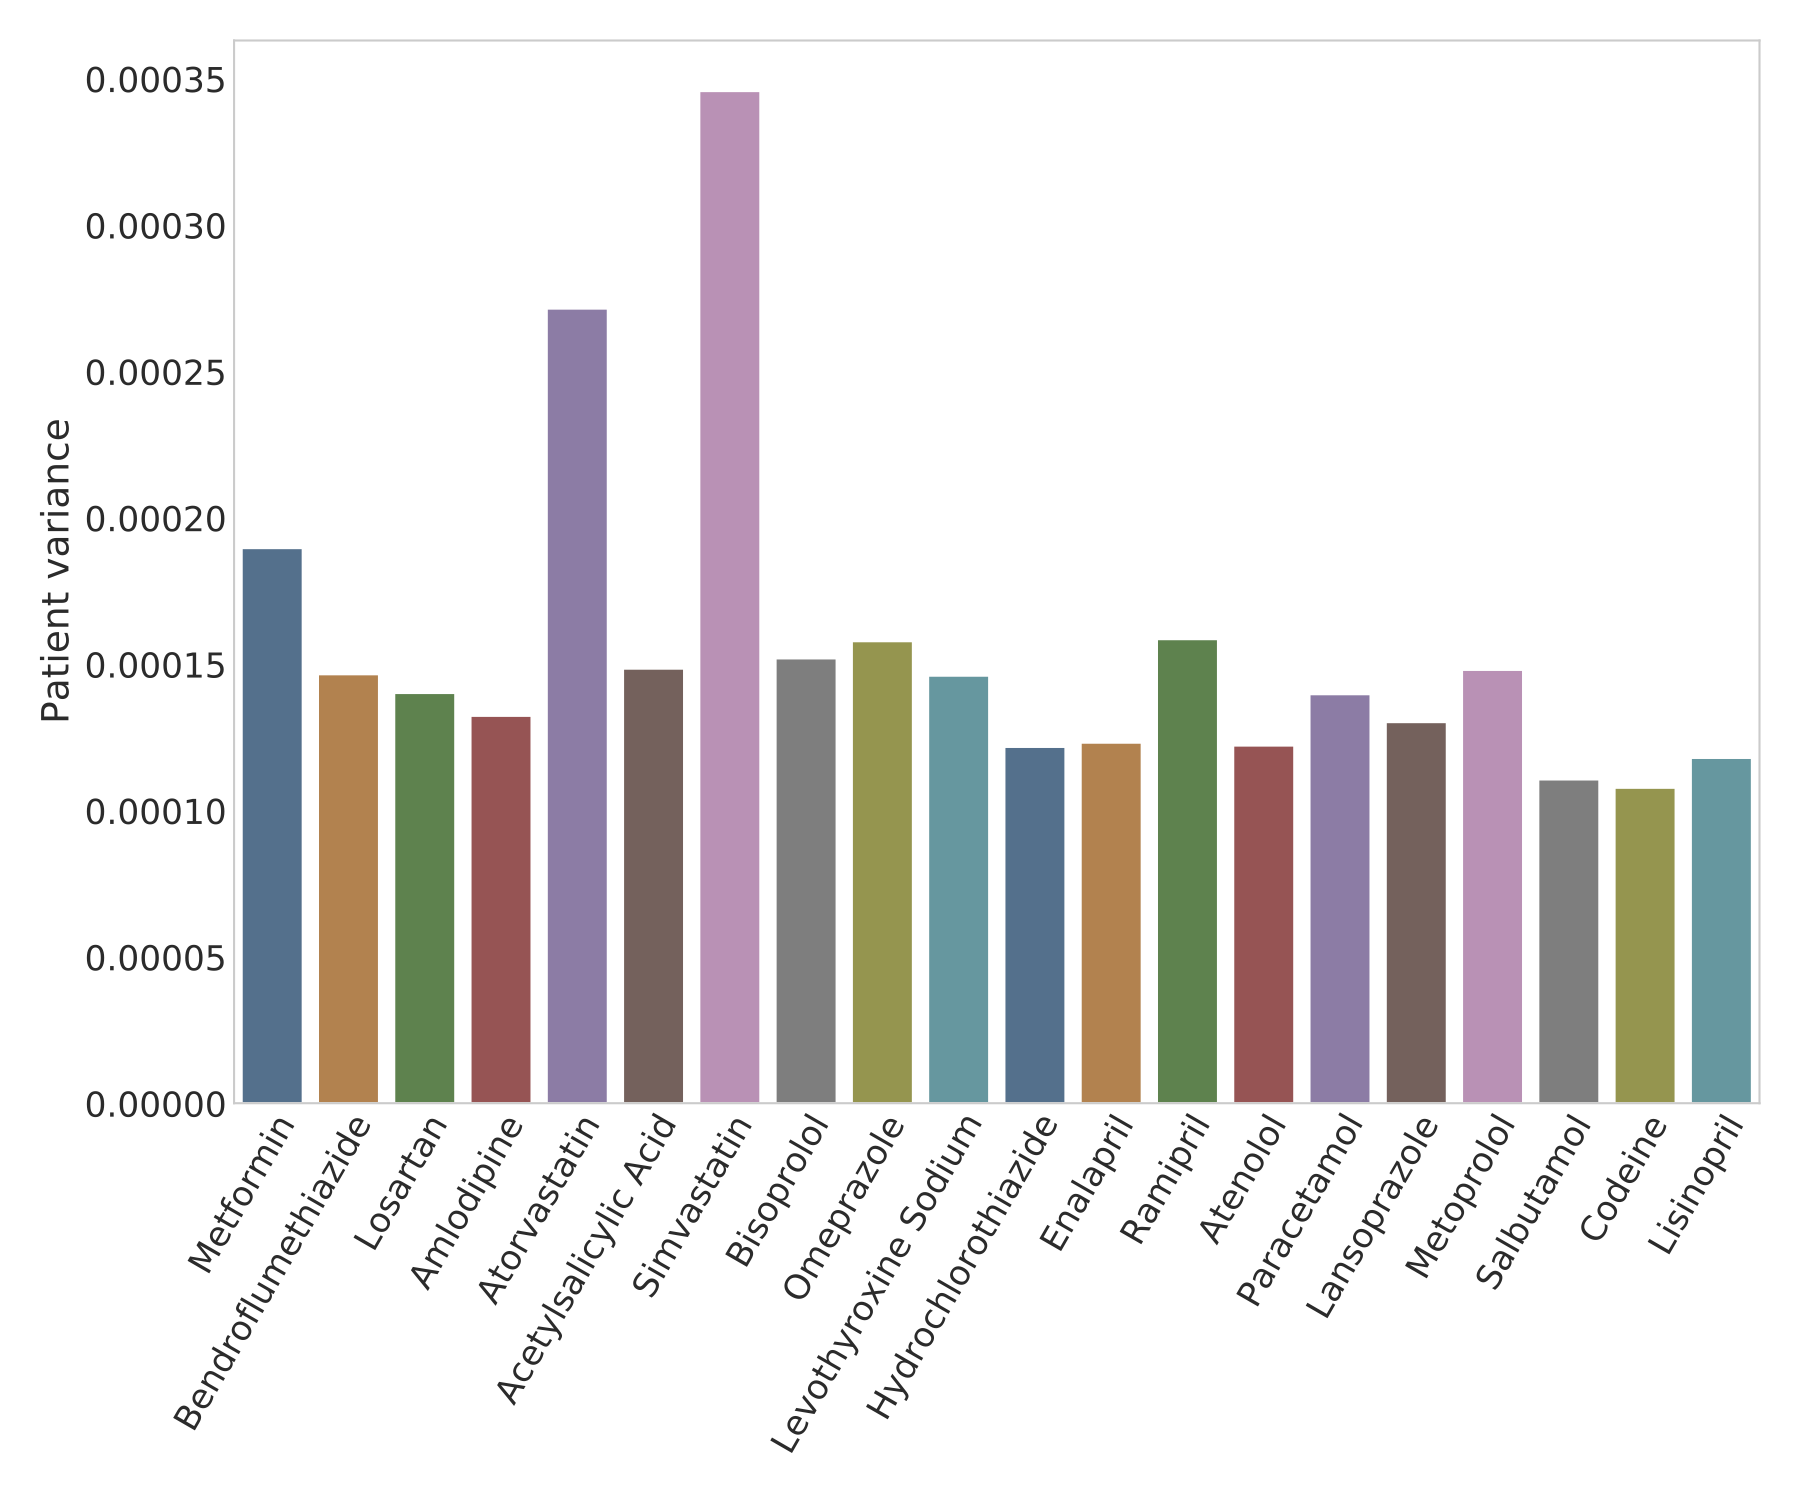

In [ ]:
# Drug similarity across all
def visualize_drug_similarity_across_all(recon_average_corr_new_all, drug_h, version):
    
   cos_sim = cosine_similarity(recon_average_corr_new_all)

   corr = pd.DataFrame(cos_sim, columns = drug_h, index = drug_h)
   cmap = sns.diverging_palette(220, 10, as_cmap=True)
   sns.set(font_scale=1.5)
   f, ax = plt.subplots(figsize=(10, 10))

   g = sns.clustermap(corr, cmap=cmap, center=0, xticklabels = True,
                      yticklabels = True,
                      linewidths=0, row_cluster=True, col_cluster=True, metric='correlation')

   plt.savefig(path + "results/heatmap_" + version + "_all.pdf", format = 'pdf', dpi = 800)

visualize_drug_similarity_across_all(recon_average_corr_new_all, drug_h, version)

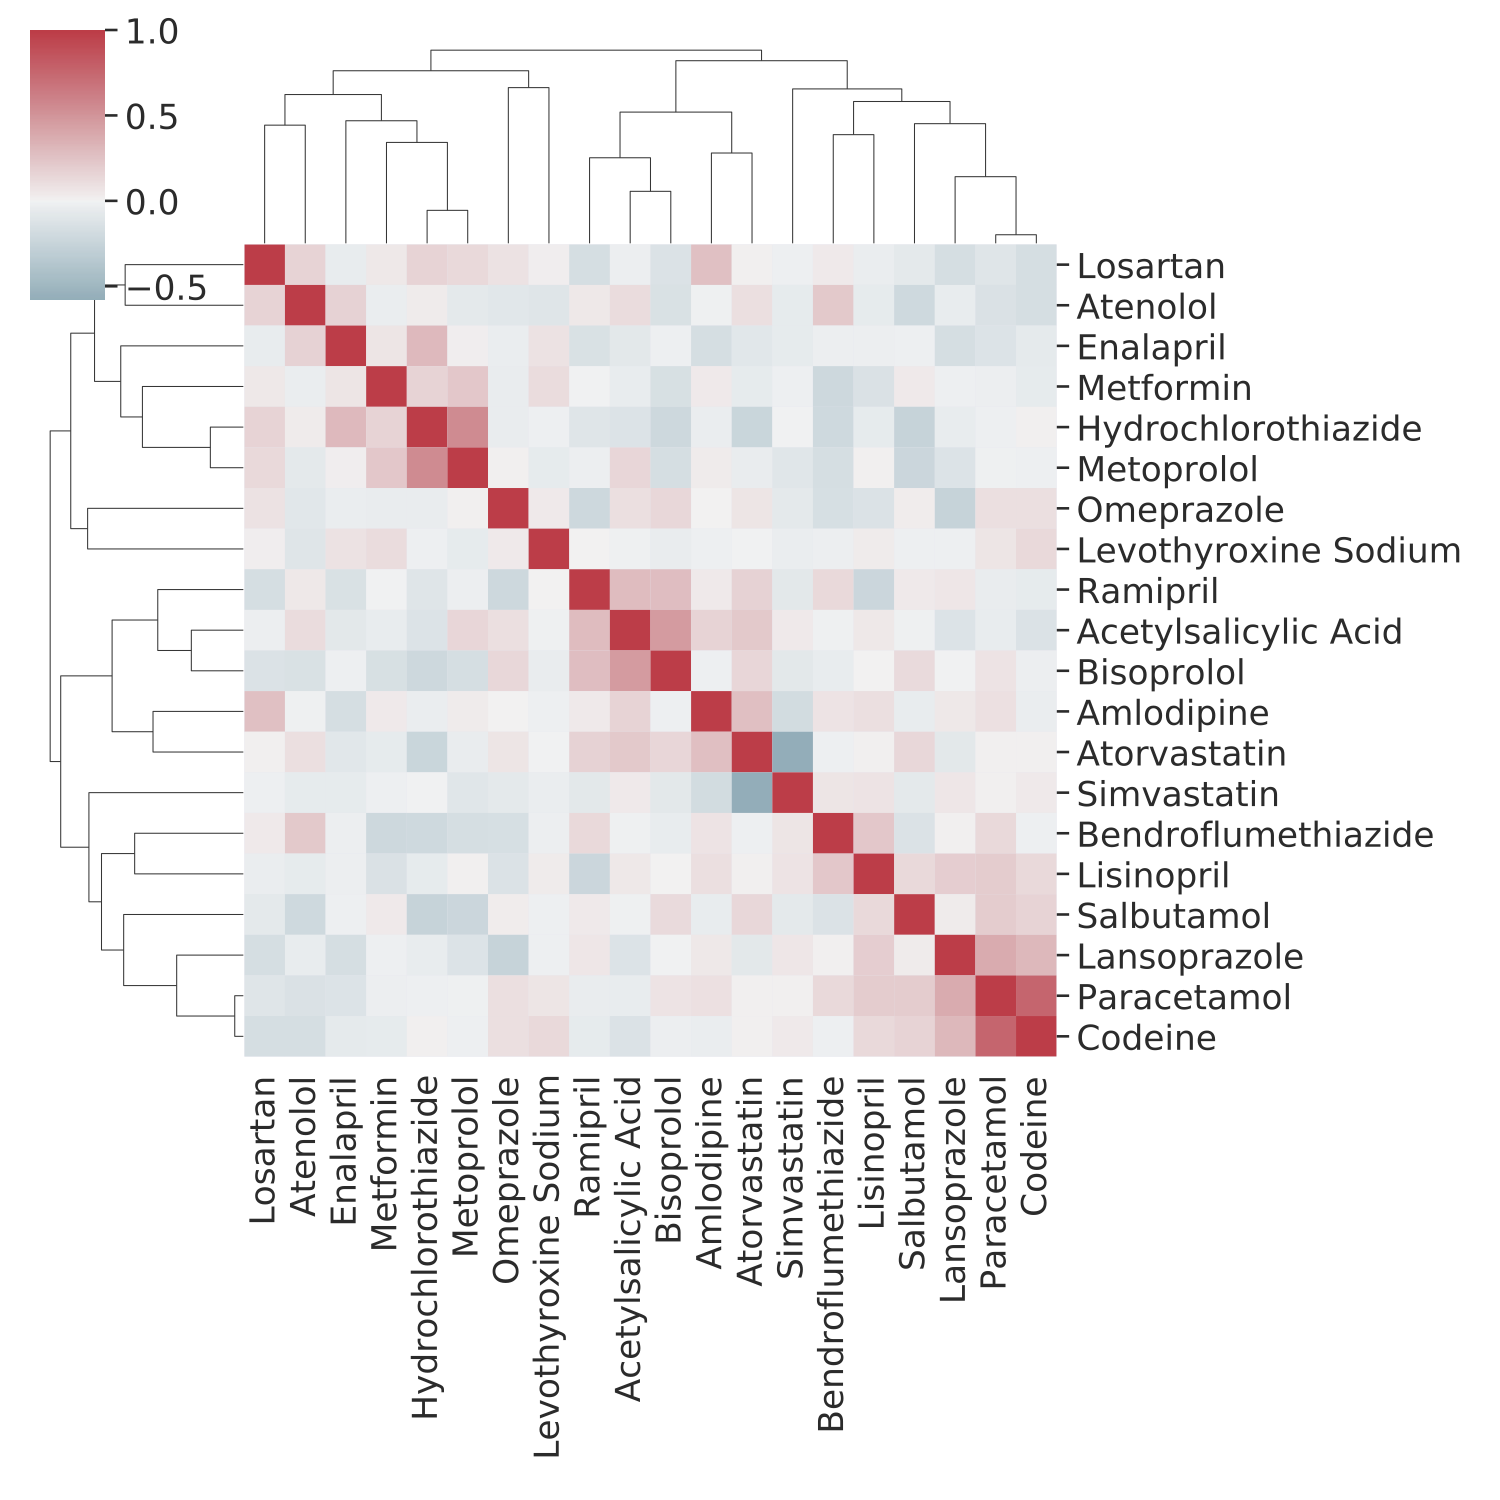

In [ ]:
# Drug similarity each omics and clinical

def get_drug_similar_each_omics(con_names, con_dataset_names, all_hits, recon_average_corr_new_all, drug_h, version):

#    con_names = [con_h, diet_wearables_h, pro_h, targm_h, untargm_h, tran_h, meta_h]
#    con_dataset_names_v1 = ['Clinical continuous', 'Diet and wearables','Proteomics','Targeted metabolomics','Unargeted metabolomics', 'Transcriptomics', 'Metagenomics'] #TODOs define outside maybe
#    con_dataset_names = ['Clinical_continuous', 'Diet_wearables','Proteomics','Targeted_metabolomics','Unargeted_metabolomics', 'Transcriptomics', 'Metagenomics']
   
   con_dataset_names_v1 = con_dataset_names # TODO define the names for plot drawing 
   i = 0
   for n in con_names:
       tmp = np.intersect1d(all_hits, n)
       if len(tmp) == 0:
           continue

       sig_data = recon_average_corr_new_all[:,np.where(np.isin(all_hits,n))[0]]
       sim = cosine_similarity(sig_data)
       corr = pd.DataFrame(sim, columns = drug_h, index = drug_h)
       sig_data = pd.DataFrame(corr, columns = drug_h, index = drug_h)
       g = sns.clustermap(sig_data, cmap=cmap, center=0, xticklabels = True,
                     yticklabels = True, metric='correlation',
                     linewidths=0, row_cluster=True, col_cluster=True, figsize=(10,10))

       g.fig.suptitle(con_dataset_names_v1[i])
       g.fig.subplots_adjust(top=0.9)
       plt.savefig(path + "results/" + con_dataset_names[i] + "_heatmap_" + version + "_all.pdf", format = 'pdf', dpi = 800)
       i += 1

   plt.close('all')

get_drug_similar_each_omics(con_names, con_dataset_names, all_hits, recon_average_corr_new_all, drug_h, version)
